This file performs dimension reduction (PCA) and hierarchical clustering based on CLIP embeddings.

Task: unsupervised learning, using data-driven methods to find the organizational structure of natural social interaction video clips.  

Model: I use Principal Component Analysis (PCA) and Hierarchical Clustering.   
Since three methods have already used (Deep Learning, PCA, Hierarchical Clustering, and UMAP), I will not try K-means clustering additionally. The basic logic of performing k-means resembles hierarchical clustering.  

The models I am using are popular in the future and have not been used in my group project.

In [1]:
#%% packages

import os
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import umap

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import cv2

In [2]:
#%% video info

video_dir = '../data/MiT_original_videos'
video_name_list = [f for f in os.listdir(video_dir) if f.endswith('.mp4')]

In [3]:
# %% Load embeddings

clip_features_df = pd.read_csv('../data/annotations/NN/CLIP/CLIP_df.csv')
clip_features_df.head()

,video_name,CLIP_1,CLIP_2,CLIP_3,CLIP_4,CLIP_5,CLIP_6,CLIP_7,CLIP_8,CLIP_9,...,CLIP_503,CLIP_504,CLIP_505,CLIP_506,CLIP_507,CLIP_508,CLIP_509,CLIP_510,CLIP_511,CLIP_512
0,flickr-1-0-3-5-1-1-0-6-2810351106_1.mp4,0.399409,0.098144,0.336123,0.212568,0.205054,-0.198757,-0.121979,-0.080687,-0.423351,...,0.008833,0.140616,-0.550720,-0.525530,0.185082,-0.081566,-0.519114,0.820222,0.294057,-0.069468
1,yt-lzsldb9fo70_4.mp4,0.511724,-0.047960,0.426349,0.146953,0.139034,-0.386607,0.568859,-0.033577,-0.243532,...,0.105952,0.432048,-0.403030,-0.472138,0.279215,-0.180634,-0.311724,0.765456,0.029665,0.102111
2,flickr-5-0-2-0-2-2-2-2-2450202222_18.mp4,0.502526,0.273570,0.394841,0.338357,-0.175621,-0.362369,0.142959,0.133354,0.278705,...,0.537802,0.116195,-0.602853,-0.313012,0.342610,-0.039725,-0.183272,0.470634,-0.274063,-0.118520
3,yt-9OU9ycaIiGM_35.mp4,-0.109598,0.005119,0.068176,0.243780,-0.063843,0.009338,0.054916,-0.050245,-0.000977,...,0.143147,0.011908,-0.459566,-0.584713,-0.294732,0.228543,-0.555814,0.658205,0.083701,0.126681
4,yt-KZqqB7yoVYw_11.mp4,0.341397,-0.193583,-0.114195,-0.185415,0.072114,-0.271012,-0.335887,-0.246907,-0.439016,...,0.024262,-0.118878,-0.566981,-0.174445,0.019620,0.084513,-0.352776,0.307269,-0.048337,0.164713


In [4]:
# %% functions

def preprocess_features_PCA(features_df):
    """
    Preprocess features using PCA dimensionality reduction
    
    Args:
        features_df: DataFrame of features (with video_name as the first column)
    
    Returns:
        features_df_reduced: DataFrame with video_name and PCA-reduced features
    """
    
    # Extract features without video name column
    features = features_df.iloc[:, 1:]
    
    np.random.seed(115)
    # Fit PCA without limiting components
    pca = PCA()
    features_reduced = pca.fit_transform(features)
    
    # Calculate explained variance ratio
    explained_var_ratio = pca.explained_variance_ratio_
    cumulative_var_ratio = np.cumsum(explained_var_ratio)
    
    # Plots
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(explained_var_ratio) + 1), explained_var_ratio, 'bo-')
    plt.axvline(x=np.argmax(cumulative_var_ratio >= 0.9) + 1, color='k', linestyle='--', label='90% Components')
    plt.title('Component Explained Variance')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_var_ratio) + 1), cumulative_var_ratio, 'ro-')
    plt.axhline(y=0.9, color='k', linestyle='--', label='90% Threshold')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Find number of components for 90% variance
    n_components = np.argmax(cumulative_var_ratio >= 0.9) + 1
    
    # Reduce to optimal number of components
    pca = PCA(n_components=n_components)
    features_reduced = pca.fit_transform(features)
    
    # Create DataFrame with reduced features
    features_df_reduced = pd.DataFrame(
        features_reduced,
        columns=[f'PC_{i}' for i in range(features_reduced.shape[1])]
    )
    features_df_reduced.insert(0, 'video_name', features_df['video_name'])
    
    return features_df_reduced

def hierarchical_clustering(features_df_pca, n_clusters=None, hc_linkage_method='ward', hc_criterion='maxclust', display=True):
    """
    Perform hierarchical clustering on PCA-reduced features and plot dendrogram
    
    Args:
        features_df_pca (pd.DataFrame): DataFrame with PCA-reduced features.
        n_clusters (int): Number of clusters to generate. If None, finds optimal number.
        hc_linkage_method (str): Linkage method for hierarchical clustering.
        hc_criterion (str): Criterion for forming flat clusters.
        display (bool): Whether to display the dendrogram plot.
    
    Returns:
        tuple: (cluster_labels, silhouette_score) - Cluster assignments and silhouette score
    """
    # If n_clusters is None, find optimal number (between 2 and 10) through silhouette scores
    if n_clusters is None:
        silhouette_scores = []
        n_clusters_range = range(2, 11)
        
        for k in n_clusters_range:
            _, score = hierarchical_clustering(features_df_pca, k, 
                                                  hc_linkage_method, hc_criterion, 
                                                  display=False)
            silhouette_scores.append(score)
            

        
        # Get optimal number of clusters
        n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
        print(f"Optimal number of clusters: {n_clusters}")

        # Plot silhouette scores
        plt.figure(figsize=(10, 6))
        plt.plot(n_clusters_range, silhouette_scores, 'bo-')
        plt.title('Silhouette Scores Plot', fontsize=22)
        plt.axvline(x=n_clusters, color='k', linestyle='--', label=f'Optimal Number of Clusters (k={n_clusters})')
        plt.xlabel('Number of Clusters', fontsize=18)
        plt.ylabel('Silhouette Score', fontsize=18)
        plt.tight_layout()
        plt.show()
        
    # Perform hierarchical clustering, with the optimal/specified number of clusters
    linkage_matrix = linkage(features_df_pca.iloc[:, 1:], method=hc_linkage_method)
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion=hc_criterion)

    if display:
        # Plot dendrogram
        plt.figure(figsize=(10, 7))
        labels = features_df_pca['video_name'].tolist()
        
        dendro = dendrogram(linkage_matrix, 
                            labels=labels,
                            leaf_rotation=90,  
                            leaf_font_size=12,  
                            color_threshold=linkage_matrix[-n_clusters+1, 2],   
                            truncate_mode='lastp',
                            above_threshold_color='gray',
                            show_contracted=True,
                            show_leaf_counts=True) 
     
        # Add a horizontal line at the threshold
        threshold = linkage_matrix[-n_clusters+1, 2] 
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Cluster Cut (k={n_clusters})')

        plt.title(f'Hierarchical Clustering of Videos (k={n_clusters})', fontsize=22)
        plt.xlabel('Video Names', fontsize=18)
        plt.ylabel('Distance', fontsize=18)
        plt.legend(fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.tight_layout()
        plt.show()

    # Calculate silhouette score
    score = silhouette_score(features_df_pca.iloc[:, 1:], cluster_labels)

    return cluster_labels, score

def extract_frame(video_name, video_dir='../data/MiT_original_videos', target_size=224):
    """
    Extract first frame from a video and process it to a square shape
    
    Args:
        video_name (str): Name of the video file
        video_dir (str): Directory containing the video
        target_size (int): Target size for the square frame
        
    Returns:
        frame: First frame of the video in RGB format, cropped to square and resized
    """
    # Open video file
    video_path = os.path.join(video_dir, video_name)
    cap = cv2.VideoCapture(video_path)
    
    # Read first frame
    ret, frame = cap.read()
    if ret:
        # Convert to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Crop to square using shorter edge
        height, width = frame_rgb.shape[:2]
        
        if height > width:
            start = (height - width) // 2
            frame_rgb = frame_rgb[start:start+width, :, :]
        else:
            start = (width - height) // 2
            frame_rgb = frame_rgb[:, start:start+height, :]
            
        # Resize to target size
        frame_rgb = cv2.resize(frame_rgb, (target_size, target_size))
    else:
        frame_rgb = None
    
    # Release video capture
    cap.release()
    return frame_rgb

def visualize_embeddings_umap(pca_feature_df, video_name_list, hc_cluster_results, cluster_mapping):
    """Visualize video embeddings in 2D using UMAP, with representative video frames for each cluster.
    
    Args:
        pca_feature_df: DataFrame with PCA features
        video_name_list: List of video names
        hc_cluster_results: Cluster labels from hierarchical clustering
        cluster_mapping: Dictionary mapping cluster labels to interpretable categories
    """
    # Drop video name column if exists
    features = pca_feature_df.iloc[:, 1:] if 'video_name' in pca_feature_df.columns else pca_feature_df
    
    # Reduce to 2D using UMAP for visualization
    reducer = umap.UMAP(n_components=2, random_state=42)
    embeddings_2d = reducer.fit_transform(features)

    plt.figure(figsize=(12, 8))
    
    unique_clusters = np.sort(np.unique(hc_cluster_results))
    n_clusters = len(unique_clusters)
    colors = plt.cm.Dark2(np.linspace(0, 1, n_clusters))
    custom_cmap = ListedColormap(colors)
    
    label_to_index = {label: i for i, label in enumerate(unique_clusters)}
    numeric_labels = np.array([label_to_index[label] for label in hc_cluster_results])
    
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=numeric_labels, cmap=custom_cmap, alpha=0.8)
    
    n_clusters = len(unique_clusters)
    cbar = plt.colorbar(scatter, ticks=[(1+i)*n_clusters/(n_clusters+1)-0.5 for i in range(n_clusters)])
    cbar.set_ticklabels([cluster_mapping.get(c, 'unknown') for c in unique_clusters])
    cbar.ax.set_xlabel('Category', fontsize=12)

    # Find display representative video frames for each cluster
    display_indices = []
    for cluster in unique_clusters:
        cluster_indices = np.where(hc_cluster_results == cluster)[0]
        if len(cluster_indices) > 0:
            cluster_center = np.mean(embeddings_2d[cluster_indices], axis=0)
            distances = np.linalg.norm(embeddings_2d[cluster_indices] - cluster_center, axis=1)
            closest_indices = cluster_indices[np.argsort(distances)[:3]]
            display_indices.extend(closest_indices)

    # Add slight offset to avoid overlap
    offset_step = 0.3  # Step size for offset
    offset_idx = 0  # Counter for alternating offsets
    
    for idx in display_indices:
        if idx >= len(video_name_list):
            continue
            
        thumbnail = extract_frame(video_name_list[idx], target_size=100)
        if thumbnail is not None:
            try:
                # Add colored border
                cluster_idx = label_to_index[hc_cluster_results[idx]]
                border_color = colors[cluster_idx]
                border_width = 6
                bordered_thumbnail = np.pad(thumbnail, 
                                         ((border_width, border_width), 
                                          (border_width, border_width), 
                                          (0, 0)), 
                                         mode='constant')
                
                for i in range(3):
                    bordered_thumbnail[0:border_width, :, i] = border_color[i] * 255
                    bordered_thumbnail[-border_width:, :, i] = border_color[i] * 255
                    bordered_thumbnail[:, 0:border_width, i] = border_color[i] * 255
                    bordered_thumbnail[:, -border_width:, i] = border_color[i] * 255
                
                x_offset = offset_step if offset_idx % 2 == 0 else -offset_step
                y_offset = offset_step if (offset_idx // 2) % 2 == 0 else -offset_step
                pos_x = embeddings_2d[idx, 0] + x_offset
                pos_y = embeddings_2d[idx, 1] + y_offset
                
                imagebox = OffsetImage(bordered_thumbnail, zoom=0.5)
                ab = AnnotationBbox(imagebox, (pos_x, pos_y), frameon=False)
                plt.gca().add_artist(ab)
                
                offset_idx += 1
            except Exception as e:
                print(f"Error processing thumbnail for video {video_name_list[idx]}: {str(e)}")
                continue

    plt.title('UMAP Visualization of Video Clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.margins(0.1)
    plt.tight_layout(pad=3.0)
    plt.show()
    
    # Display cluster assignments summary
    unique_labels, counts = np.unique(hc_cluster_results, return_counts=True)
    
    print("\nCluster assignments:")
    for label, count in zip(unique_labels, counts):
        category = cluster_mapping.get(label, 'unknown')
        print(f"{category}: {count} videos")

Because the number of features is greater than the number of observations, I will first use PCA to reduce the dimensionality of the features. This is also a way to reduce noise.

For principal component analysis (PCA), I use 90% cumulative explained variance as a threshold to determine the optimal number of components, which turns out to be 87 (excluding the `video_name` column)

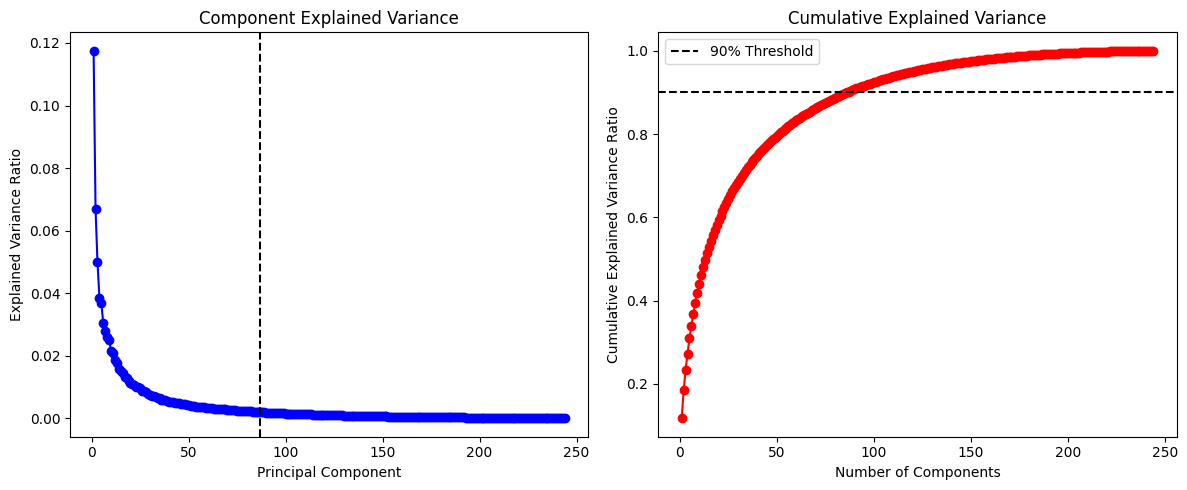

PCA features dataframe shape: (244, 88)


In [5]:
# %% main: 1. Reduce dimensionality using PCA

features_df_reduced = preprocess_features_PCA(clip_features_df) 
print("PCA features dataframe shape:", features_df_reduced.shape)

For clustering, I use hierarchical clustering because hierarchical clustering displays the *hierarchical relationship between data points through a dendrogram*, which helps to understand the internal structure of the data. K-means does not provide such an intuitive representation.  


For hierarchical clustering, I tried different **linkage** methods ('ward', 'complete', 'average', 'single') and **criteria** ('maxclust', 'distance').

Find the optimal number of clusters for each combination using **silhouette** score and determine the optimal hyperparameter combination.

The best hyperparamter combination is ward linkage with maxclust criteria, with 6 clusters to be the optimal number of clusters. Silhouette coefficient score is 0.117.

In addition, I also checked the **dendrogram** of hierarchical clustering to ensure that the different clusters obtained from cutting have good separation.

Method: ward, Criterion: maxclust, Score: 0.117
Method: ward, Criterion: distance, Score: 0.048
Method: complete, Criterion: maxclust, Score: 0.093
Method: complete, Criterion: distance, Score: 0.048
Method: average, Criterion: maxclust, Score: 0.086
Method: average, Criterion: distance, Score: 0.052
Method: single, Criterion: maxclust, Score: 0.047
Method: single, Criterion: distance, Score: 0.011


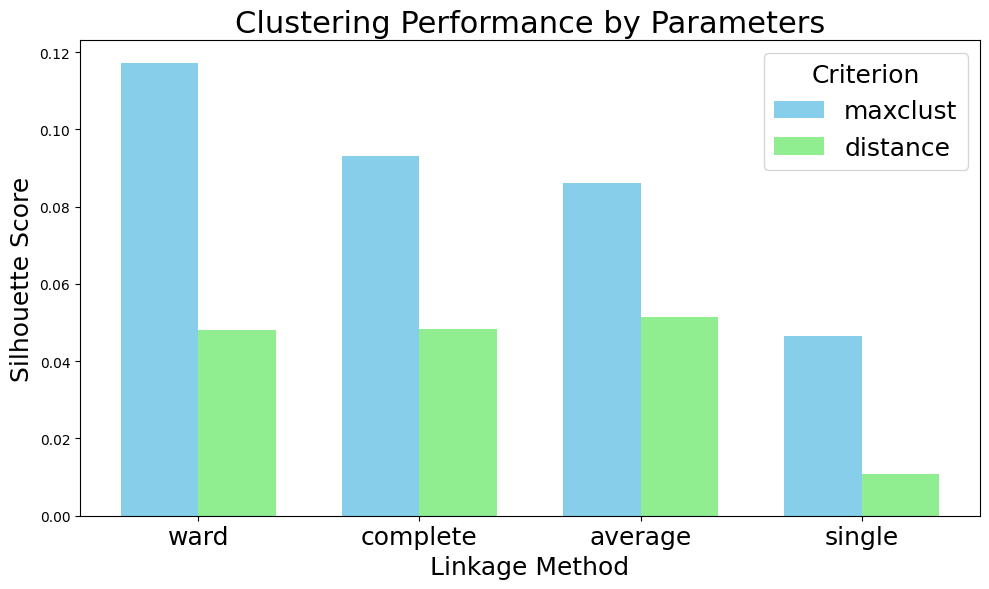


Best parameters: linkage=ward, criterion=maxclust
Best silhouette score: 0.117
Optimal number of clusters: 6


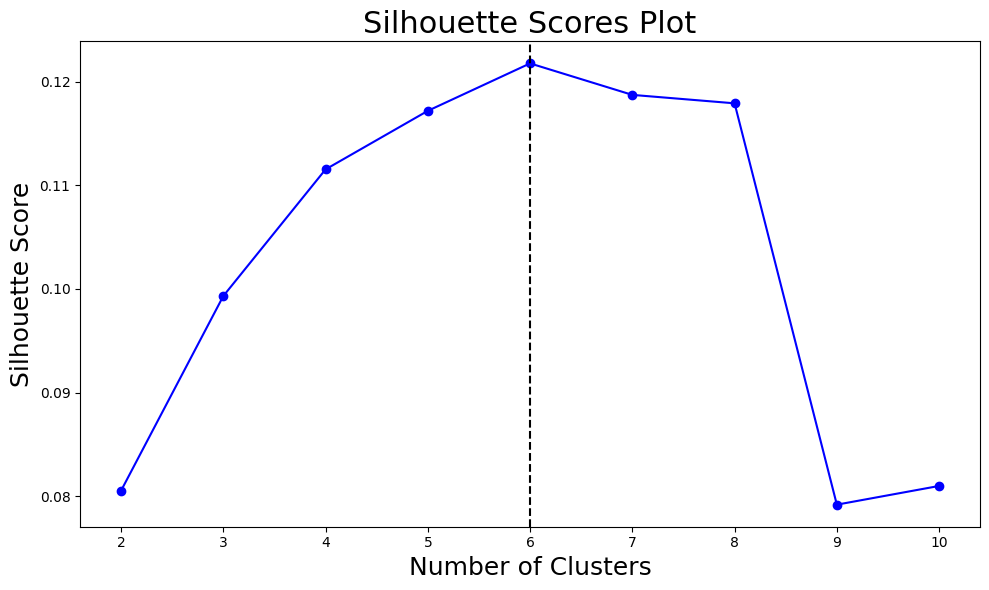

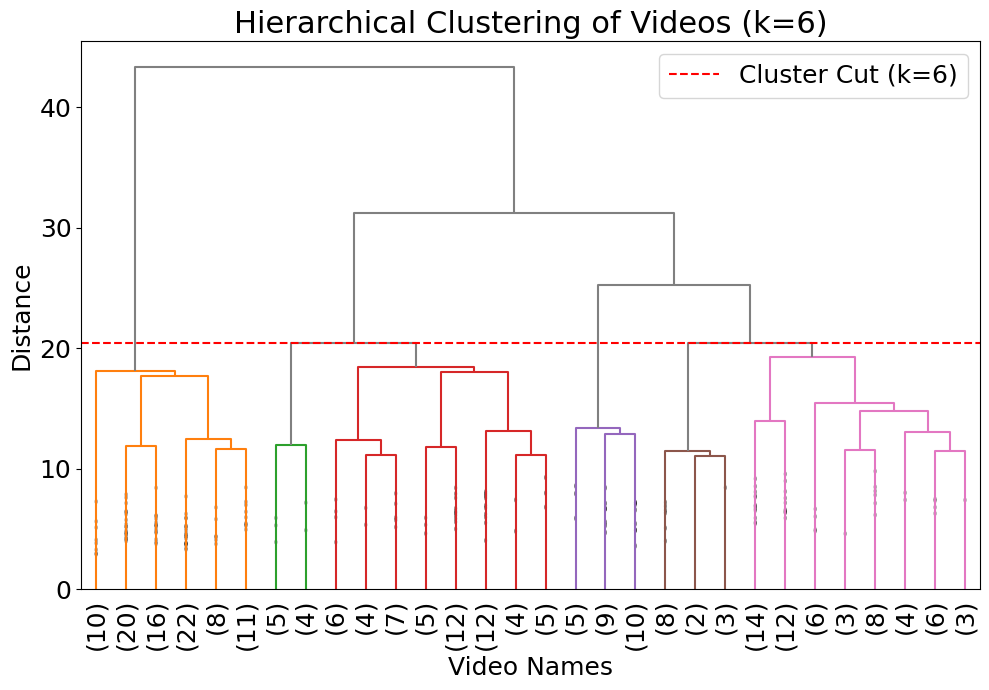

In [6]:
#%% main: 2. Clustering: grid search for best parameters

# Try different combinations of linkage methods and criteria
linkage_methods = ['ward', 'complete', 'average', 'single']
criteria = ['maxclust', 'distance']

best_score = -1
best_labels = None
best_params = None
# Store results for plotting
results = []

for method in linkage_methods:
    for criterion in criteria:
        try:
            labels, score = hierarchical_clustering(features_df_reduced, 
                                                  n_clusters=5,
                                                  hc_linkage_method=method,
                                                  hc_criterion=criterion, 
                                                  display=False)
            print(f"Method: {method}, Criterion: {criterion}, Score: {score:.3f}")
            results.append((method, criterion, score))
            
            if score > best_score:
                best_score = score
                best_labels = labels
                best_params = (method, criterion)
        except:
            continue

# Convert results to DataFrame for plotting
results_df = pd.DataFrame(results, columns=['Method', 'Criterion', 'Score'])
# Create grouped bar plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(linkage_methods))

plt.bar(x - bar_width/2, 
        results_df[results_df['Criterion'] == 'maxclust'].Score,
        bar_width, 
        label='maxclust',
        color='skyblue')
plt.bar(x + bar_width/2,
        results_df[results_df['Criterion'] == 'distance'].Score,
        bar_width,
        label='distance', 
        color='lightgreen')

plt.xlabel('Linkage Method', fontsize=18)
plt.ylabel('Silhouette Score', fontsize=18)
plt.title('Clustering Performance by Parameters', fontsize=22)
plt.xticks(x, linkage_methods, fontsize=18)
plt.legend(fontsize=18, title='Criterion',title_fontsize=18)
plt.tight_layout()
plt.show()

print(f"\nBest parameters: linkage={best_params[0]}, criterion={best_params[1]}")
print(f"Best silhouette score: {best_score:.3f}")

# Run clustering with best parameters and display results
hc_cluster_labels, hc_silhouette_score = hierarchical_clustering(features_df_reduced,
                                                               n_clusters=None,
                                                               hc_linkage_method=best_params[0],
                                                               hc_criterion=best_params[1],
                                                               display=True)

Finally, to interpret the clustering results, I visualized all the videos in a 2D space using the **UMAP** method, which is based on the ideas of manifold learning and topology, able to embed data from a high-dimensional space to a low-dimensional space while preserving the local and global structures of the data.

I exhibit frames of the representative videos (the three videos closest to the centroid in each cluster) to gain a intuitive understanding of the clustering results.

/opt/anaconda3/envs/MACSS/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/MACSS/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


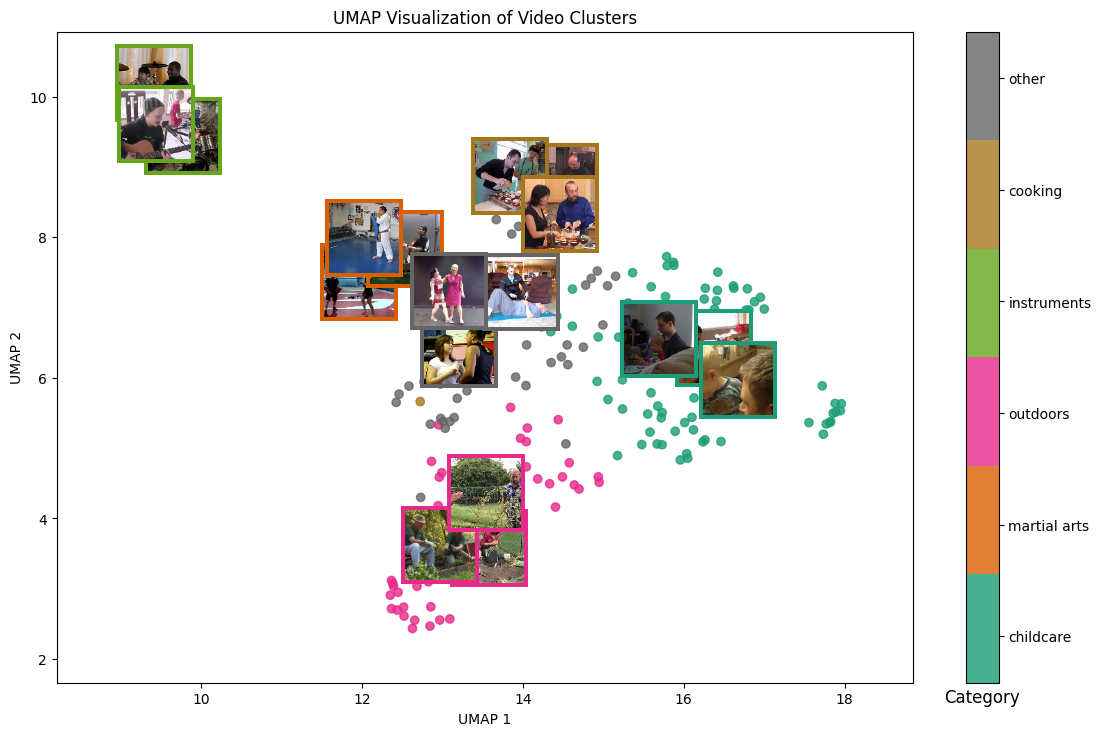


Cluster assignments:
childcare: 87 videos
martial arts: 9 videos
outdoors: 55 videos
instruments: 24 videos
cooking: 13 videos
other: 56 videos


In [7]:
#%% main: 3. Visualize clusters

# Map cluster labels to interpretable categories
category_mapping = {
    1: 'childcare',
    2: 'martial arts', 
    3: 'outdoors',
    4: 'instruments',
    5: 'cooking',
    6: 'other'
}

# Visualize clusters using UMAP
visualize_embeddings_umap(features_df_reduced, 
                         video_name_list,
                         hc_cluster_labels, 
                         category_mapping)

There are 6 clusters emerged.  

They are featured by different activities, like martical art, cooking; or different scenes, like outdoors; or different demographics, like childcare. 

In a word, this clustering results indicate that:  
1. the CLIP model is powerful in the sense that it can capture the semantic information of the videos.
2. This organizational structure of natural stimuli emphasizes that when we consider social interaction, *where, who and what* matter.

The future work may involve exploring the relationship between this representational structure and human semantic, behavioral or neural representation of social interaction.